# Project 2 - Ames housing sales price analysis (Part 2 of 3)

## Import Libraries and Data

In [1]:
# import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import pickle

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV, ElasticNetCV, ElasticNet
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# import cleaned dataset
ames3 = pd.read_csv('../datasets/ames3_data.csv')

# Modelling - Selection of Variables

Comment:\
I am aware that some of my teammates have consulted and been advised to let Lasso help with variable/feature selection or a backwards elimination method.\
However, at risk of being perceived as lazy? I have made a conscious decision to do a forward selection method for a few reasons:
- Brute force method is not as elegant or as scientific, and I understand that domain knowledge is often essential as correlation does not translate to causation and could happen by mere chance, especially in a large dataset.
- Real life applicability is more important in my humble view, and I am of the opinion that brute force might not always be feasible... depending on the data and the amount of computing resource available, e.g. my teammates have shared with me how it took them 3 hours to generate their pairplots!
- Simple is better than complex, and I am willing to accept the trade-off on model accuracy but with greater ease of model interpretation that allows me to explain the magnitude of impact for each variable, thus in explaining to the layman and getting credibility. (If I really have time on hand, I would be most keen to have a shadow model that is based on brute force and compare both performance on deployment.)
- The true litmus test is its performance post deployment as production model and not a development model, so I am not keen to chase after marginal returns on R-sq, which based on my experimentation, more features have resulted in only incremental improvement of ~0.1 range.

Having said so, I may have to revert to brute force method if the outcome is less than desirable for my chosen approach.

In [3]:
# preview the imported cleaned dataset
ames3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2037 entries, 0 to 2036
Data columns (total 75 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ms_subclass        2037 non-null   int64  
 1   ms_zoning          2037 non-null   int64  
 2   lot_frontage       2037 non-null   float64
 3   lot_area           2037 non-null   int64  
 4   lot_shape          2037 non-null   int64  
 5   land_contour       2037 non-null   object 
 6   lot_config         2037 non-null   int64  
 7   neighborhood       2037 non-null   int64  
 8   condition_1        2037 non-null   int64  
 9   bldg_type          2037 non-null   int64  
 10  house_style        2037 non-null   int64  
 11  overall_qual       2037 non-null   int64  
 12  overall_cond       2037 non-null   int64  
 13  year_built         2037 non-null   int64  
 14  year_remod/add     2037 non-null   int64  
 15  roof_style         2037 non-null   object 
 16  exterior_1st       2037 

### Correlation check - pairplot

In [4]:
# take a look at the pairplot correlation of all data, including post transformation categorical data
# sns.pairplot(ames3, corner=True).savefig("./plots/ames3 pairplot.jpg");
# sns.pairplot(data=ames3, x_vars=['saleprice'], aspect = 2).savefig("../plots/ames3 pairplot sp.jpg");
# too long to load... comment out... saved as file
# actually the first pairplot might be too chunky and not that user-friendly at all
# the second one only show all plots against saleprice

### Correlation check - heatmap

In [5]:
# this also takes awhile to load, comment out, saved as file
# plt.figure(figsize=(80,80))
# mask = np.triu(np.ones_like(ames3.corr(), dtype=bool))
# sns.heatmap(ames3.corr(), annot=True, cmap="coolwarm", mask=mask)
# plt.savefig("../plots/ames3 corr.jpg");

Comments:\
The pairplots and heatmap for all the variables are chunky with low ease of inspection. While they are useful for intense scrutiny, they are probably better off as reference for the originator than any audience.\
The more useful heatmap could be the one below, where the data has been filtered and sorted in accordance to the key target variable - saleprice.

### Correlation check - single column (y-variable) heatmap

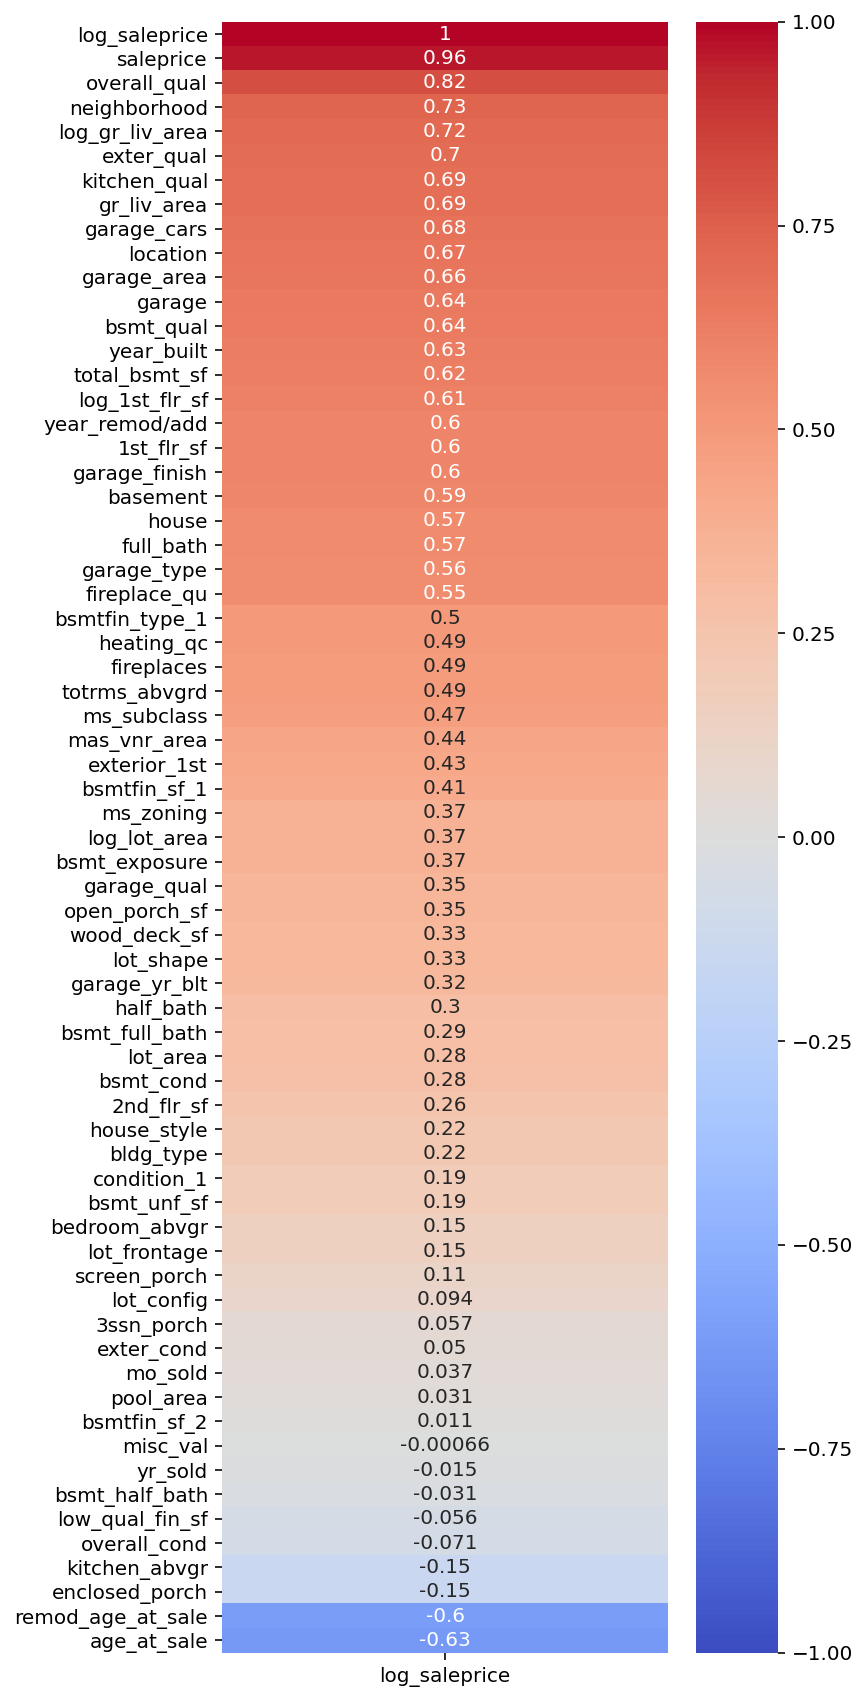

In [6]:
# single y variable heatmap
plt.figure(figsize=(5,15))
sns.heatmap(ames3.corr()[['log_saleprice']].sort_values(by='log_saleprice', ascending=False), annot=True, cmap="coolwarm", vmin=-1, vmax=1);

Comments:\
Based on the heatmap, a few variables do stand out, say those in white font with r>0.55 and r<-0.55.\
Lets take a look at these 24 features. Check for collinearity as well.\
The decision to drop the rest was premised on low correlation thus low predictability. However, I understand this need not always be true as their relationship might not be directly linear.\
This point is kept at the back of my mind. In the event that the modelling performance is inadequate, some of these variables may then be useful. Further transformation could be also necessary to demonstrate a better relationship.\
Without domain knowledge, I have chosen omit them for now.

### Model prep - variables selection based on correlation

In [7]:
# short listing the variables per above comment/decision
# year built and year remod vs. age and remod age are same data
# have chosen to retain the age instead of the year to keep the order of magnitude of values low
# this choice is deliberate as there's every chance i might not want to scale my data to preserve the readability
# of the relationship in its original scale
shortlist = ames3[['overall_qual', 'neighborhood', 'log_gr_liv_area', 'exter_qual', 'kitchen_qual', 
                   'gr_liv_area', 'garage_cars', 'location', 'garage_area', 'garage', 'bsmt_qual',
                   'total_bsmt_sf', 'log_1st_flr_sf', '1st_flr_sf', 'garage_finish', 'basement',
                   'house', 'full_bath', 'fireplace_qu', 'garage_type', 'remod_age_at_sale', 
                   'age_at_sale', 'log_saleprice']]

#shortlist.head()

### Model prep - collinearity check

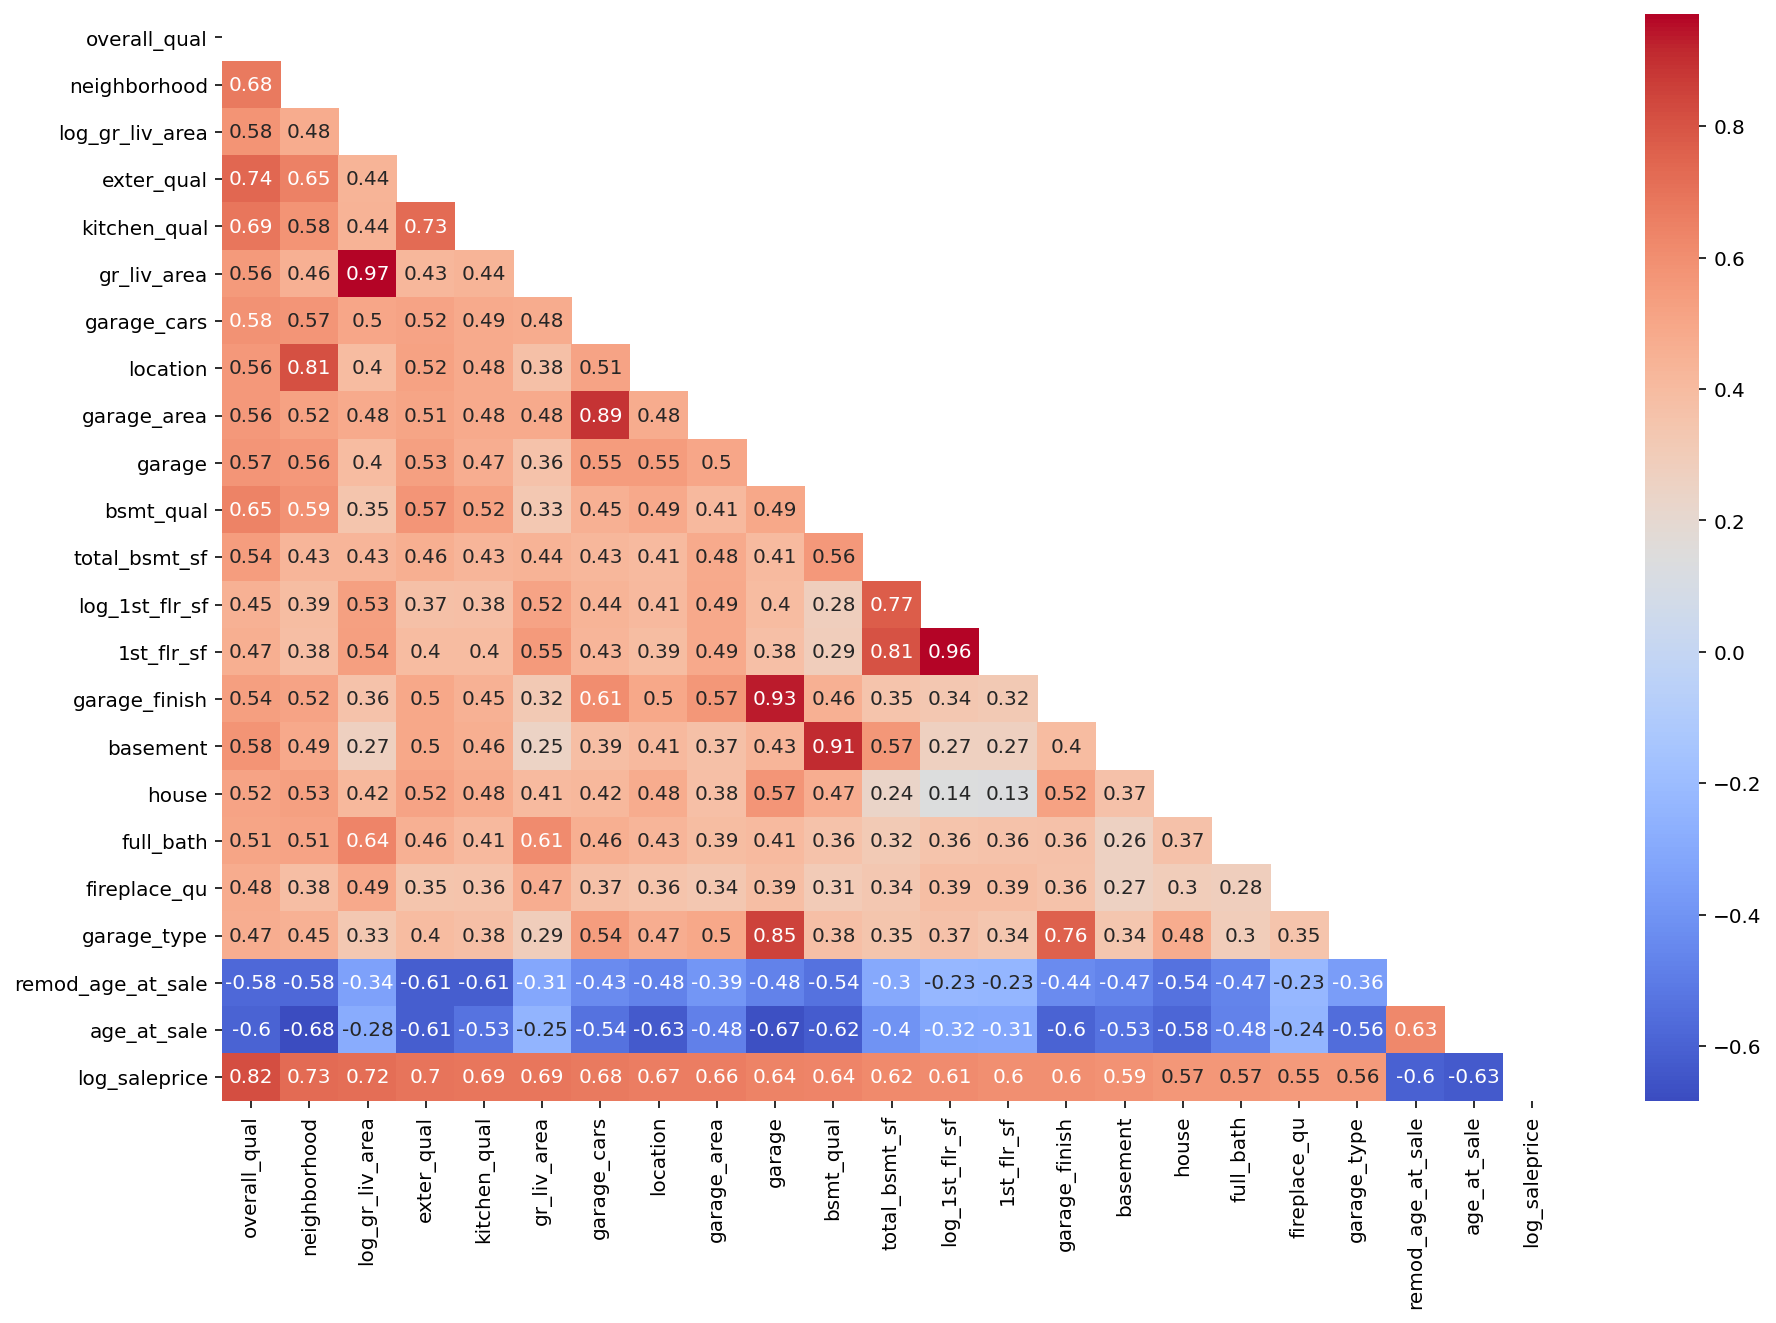

In [8]:
# plotting out these variables to observe for possible collinearity
plt.figure(figsize=(15,10))
mask = np.triu(np.ones_like(shortlist.corr(), dtype=bool))
sns.heatmap(shortlist.corr(), annot=True, cmap="coolwarm", mask=mask);

Comments:\
From the heatmap, picking up those variables with >0.7 correlation: (along axis=1)
- external quality and overall quality shows collinearity >>> choose overall quality with higher r
- location and neighborhood shows collinearity >>> choose neighborhood with higher r
- choose log grade living area vs grade living area since it has higher r
- kitchen quality and external quality also shows collinearity >>> retain kitchen quality given that external quality has been omitted
- garage area and garage cars shows collinearity >>> choose garage cars with higher r
- garage finish, garage type and garage shows collinearity >>> choose garage with higher r
- basement and basement quality shows collinearity >>> choose basement quality with higher r
- 1st floor sf (and its log fn) and total basement sf shows collinearity >>> choose log 1st floor sf as it has non-null values vs total basement with similar r

This will reduce the number of features selected down to 11, in line with the simplicity philosophy.\
Remains to be seen how the model shall perform. Stay tuned.\
Also, the chosen features are largely 'unique', in the sense that it relates to a particular part of the house, i.e. there are no parts of the house that is duplicated.\
There is 1 for overall, 1 for kitchen, 1 for basement, 1 for bath, 1 for fireplace, 1 for living area, 1 for neighbourhood, 1 for house age, 1 for remodelled age of house.\
Might consider relooking into 2 features for garage and garage cars, to see if dropping one of them makes any siginificant difference. Having said that, they actually refer to different attributes of the garage, so keeping both of them might still make sense.

### Model prep - final features/variables selection

In [9]:
features = shortlist.drop(columns = ['garage_type', 'exter_qual', 'basement', 
                                     'total_bsmt_sf', '1st_flr_sf', 'garage_area', 
                                     'location', 'garage_finish', 'house', 'gr_liv_area'])
# despite making a decision to drop these features,
# i have also experimented including all these variables and dropping them one by one
# while there 'appears' to be model 'improvement' through the inclusion of more features,
# the 'improvements' are marginal at best, i.e. improvement of R=sq<0.1 and RMSE <0.1(depending on random_state)
# therefore, i'm not as inclined to chase after the marginal returns which may not be statistically significant

In [10]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2037 entries, 0 to 2036
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   overall_qual       2037 non-null   int64  
 1   neighborhood       2037 non-null   int64  
 2   log_gr_liv_area    2037 non-null   float64
 3   kitchen_qual       2037 non-null   int64  
 4   garage_cars        2037 non-null   float64
 5   garage             2037 non-null   float64
 6   bsmt_qual          2037 non-null   float64
 7   log_1st_flr_sf     2037 non-null   float64
 8   full_bath          2037 non-null   int64  
 9   fireplace_qu       2037 non-null   float64
 10  remod_age_at_sale  2037 non-null   int64  
 11  age_at_sale        2037 non-null   int64  
 12  log_saleprice      2037 non-null   float64
dtypes: float64(7), int64(6)
memory usage: 207.0 KB


### Model prep - defining X and y variables

In [11]:
# define X and y variables
y = features['log_saleprice']
X = features.drop(columns = ['log_saleprice'])

### Model prep - scaling the variables

In [12]:
# scale the features
ss = StandardScaler()
ss.fit(X)
Xs = ss.transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns)

### Model tuning - finding a suitable random state

This is actually an iterative process as I have used linear regression for the choice of random state recursion as I have first run through all the steps to decide on my model selection.

In [13]:
# commenting out to reduce run time
# this runs seeks to identify an appropriate random_state for the modelling that gives the 'best' returns

# rmse_test = 1
# rmse_train = 1
# rsq_test = 0.1
# rsq_train = 0.1
# delta_rsq = 1
# delta_rmse = 1
# cvs_test = 0.1
# cvs_train = 0.1
# cvs_delta = 1
# for i in range(1000):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i, test_size=0.25)
#     linreg = LinearRegression()
#     linreg.fit(X_train, y_train)
    
#     rmse_test1 = np.sqrt(metrics.mean_squared_error(y_test, linreg.predict(X_test)))
#     rsq_test1 = linreg.score(X_test, y_test)
    
#     rmse_train1 = np.sqrt(metrics.mean_squared_error(y_train, linreg.predict(X_train)))
#     rsq_train1 = linreg.score(X_train, y_train)
    
#     delta_rsq1 = abs(rsq_test1 - rsq_train1)
#     delta_rmse1 = abs(rmse_test1 - rmse_train1)
    
#     cvs_train1 = cross_val_score(linreg, X_train, y_train).mean()
#     cvs_test1 = cross_val_score(linreg, X_test, y_test).mean()
#     cvs_delta1 = abs(cvs_test1 - cvs_train1)
    
#     if rmse_test1 < rmse_test:
#         rmse_test = rmse_test1
#         retain1 = i
        
#     if rsq_test1 > rsq_test:
#         rsq_test = rsq_test1
#         retain2 = i
    
#     if rmse_train1 < rmse_train:
#         rmse_train = rmse_train1
#         retain3 = i

#     if rsq_train1 > rsq_train:
#         rsq_train = rsq_train1
#         retain4 = i
    
#     if delta_rsq1 < delta_rsq:
#         delta_rsq = delta_rsq1
#         retain5 = i

#     if delta_rmse1 < delta_rmse:
#         delta_rmse = delta_rmse1
#         retain6 = i
        
#     if cvs_train1 > cvs_train:
#         cvs_train = cvs_train1
#         retain7 = i
        
#     if cvs_test1 > cvs_test:
#         cvs_test = cvs_test1
#         retain8 = i
        
#     if cvs_delta1 < cvs_delta:
#         cvs_delta = cvs_delta1
#         retain9 = i
    
        
# print(f'lowest rmse test = {rmse_test}, random_state = {retain1}')
# print(f'lowest rmse train = {rmse_train}, random_state = {retain3}\n')

# print(f'highest rsq test = {rsq_test}, random_state = {retain2}')
# print(f'highest rsq train = {rsq_train}, random_state = {retain4}\n')

# print(f'lowest rsq delta = {delta_rsq}, random_state = {retain5}')
# print(f'lowest rmse delta = {delta_rmse}, random_state = {retain6}\n')

# print(f'highest cvs train = {cvs_train}, random_state = {retain7}')
# print(f'highest cvs test = {cvs_test}, random_state = {retain8}')
# print(f'lowest cvs delta = {cvs_delta}, random_state = {retain9}')

To minimize run time for submission, am displaying the above output below.

Output:\
lowest rmse test = 0.1244723594456003, random_state = 392\
lowest rmse train = 0.1322733312423179, random_state = 852

highest rsq test = 0.8994023783841693, random_state = 426\
highest rsq train = 0.8849695314961796, random_state = 460

lowest rsq delta = 1.1431237155967722e-05, random_state = 17\
lowest rmse delta = 5.626889690357739e-06, random_state = 724

highest cvs train = 0.8823921932177152, random_state = 460\
highest cvs test = 0.897780861472784, random_state = 998\
lowest cvs delta = 2.708525249639493e-07, random_state = 839

Comments:\
Rationalizing the choice of random_state...\
Have decided to use the one with lowest RMSE delta between train and test rather than going for the with lowest absolute RMSE or highest absolute R-sq.\
Given that the Kaggles scoring criteria is based on RMSE, having a more reliable and robust model would be preferred instead of one with higher variance between train and test, such that hopefully it would perform reliably and predictably on unseen data.\
The lowest RMSE results and having a variance between train and test scores may be an indication of how the data is split between train and test. And the low test RMSE could simply be down to luck on how the test dataset is split, perhaps less stratified?\
Therefore, the choice for random_state has been settled at 724, lowest RMSE difference between train and test.\
Even so, it remains to be seen how it performs in reality. Continuous tuning and optimization based on its performance on deployment is more important and one should be mindful of over optimizing on train dataset.

### Model prep - train test split

In [14]:
# train test split
rs = 724
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, y, random_state=rs, test_size=0.25)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs, test_size=0.25)

In [15]:
# export X_train, X_test, y_train, y_test to verify model integrity is saved in pickle
X_train.to_csv('../datasets/x_train.csv', index=False)
X_test.to_csv('../datasets/x_test.csv', index=False)
y_train.to_csv('../datasets/y_train.csv', index=False)
y_test.to_csv('../datasets/y_test.csv', index=False)

### Model fitting

In [16]:
# fit the baseline model linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### Hyperparameter tuning of lasso alpha and fitting

In [17]:
# discovered that lasso works better with scaled data
lassocv = LassoCV(n_alphas = 300)
lassocv.fit(Xs_train, ys_train)
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xs_train, ys_train)
print(lassocv.alpha_)

0.00035461130725983423


### Hyperparameter tuning for ridge alpha and fitting

In [18]:
# from the experimentation, realized the scaling or not scaling for ridge does not seem to make any difference
# given the disadvantage of scaling is the reduced interpretability of the coefficient
# hence have decided to use the unscaled variables for modelling
ridgecv = RidgeCV(alphas = np.logspace(-6,6,13))
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

1.0

In [19]:
# impose the new boundary to finetune the alpha for ridge
ridgecv = RidgeCV(alphas = np.logspace(0.1,10,10000))
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

1.6325680281830652

In [20]:
# use the optimum alpha for ridge regression
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(X_train, y_train)

Ridge(alpha=1.6325680281830652)

### Modelling - coefficient check

In [21]:
# take a look at the coefficients for lasso, whether there are any features that we can drop
pd.DataFrame(zip(X_train.columns, lasso.coef_), columns = ['feature', 'coef'])
# separately but not demonstrated here, lasso does help to remove some features when i included 
# all the 22 features as discussed above into the runs
# in this case, i am satisfied that all the included variables are useful, 
# as they all have similar 0.0x order of magnitude except for log_gr_liv_area having a higher coefficient

,feature,coef
0,overall_qual,0.076759
1,neighborhood,0.048091
2,log_gr_liv_area,0.101313
3,kitchen_qual,0.039826
4,garage_cars,0.034371
5,garage,0.030759
6,bsmt_qual,0.036780
7,log_1st_flr_sf,0.057689
8,full_bath,-0.018501
9,fireplace_qu,0.031190


In [22]:
# taking a look at the coefficients for ridge
# except for remod_age_at_sale and age_at_sale, which are of smaller orders of magnitude
# the magnitude of the rest of coefficients looks fine
# but this is somewhat expected, as the age have higher order of magnitude than the rest of features
pd.DataFrame(zip(X_train.columns, ridge.coef_), columns = ['feature', 'coef'])

,feature,coef
0,overall_qual,0.055259
1,neighborhood,0.072993
2,log_gr_liv_area,0.314806
3,kitchen_qual,0.060234
4,garage_cars,0.045782
5,garage,0.007048
6,bsmt_qual,0.041226
7,log_1st_flr_sf,0.179279
8,full_bath,-0.033805
9,fireplace_qu,0.017665


In [23]:
# given that ridge scores are similar to linear regression, take a look at linear regression coefficients
lr_coef = pd.DataFrame(zip(X_train.columns, lr.coef_), columns = ['feature', 'coef_(A)'])
lr_coef

,feature,coef_(A)
0,overall_qual,0.054738
1,neighborhood,0.073011
2,log_gr_liv_area,0.323098
3,kitchen_qual,0.060082
4,garage_cars,0.045313
5,garage,0.006991
6,bsmt_qual,0.041331
7,log_1st_flr_sf,0.180217
8,full_bath,-0.036363
9,fireplace_qu,0.017307


### Modelling - preview R-sq plot

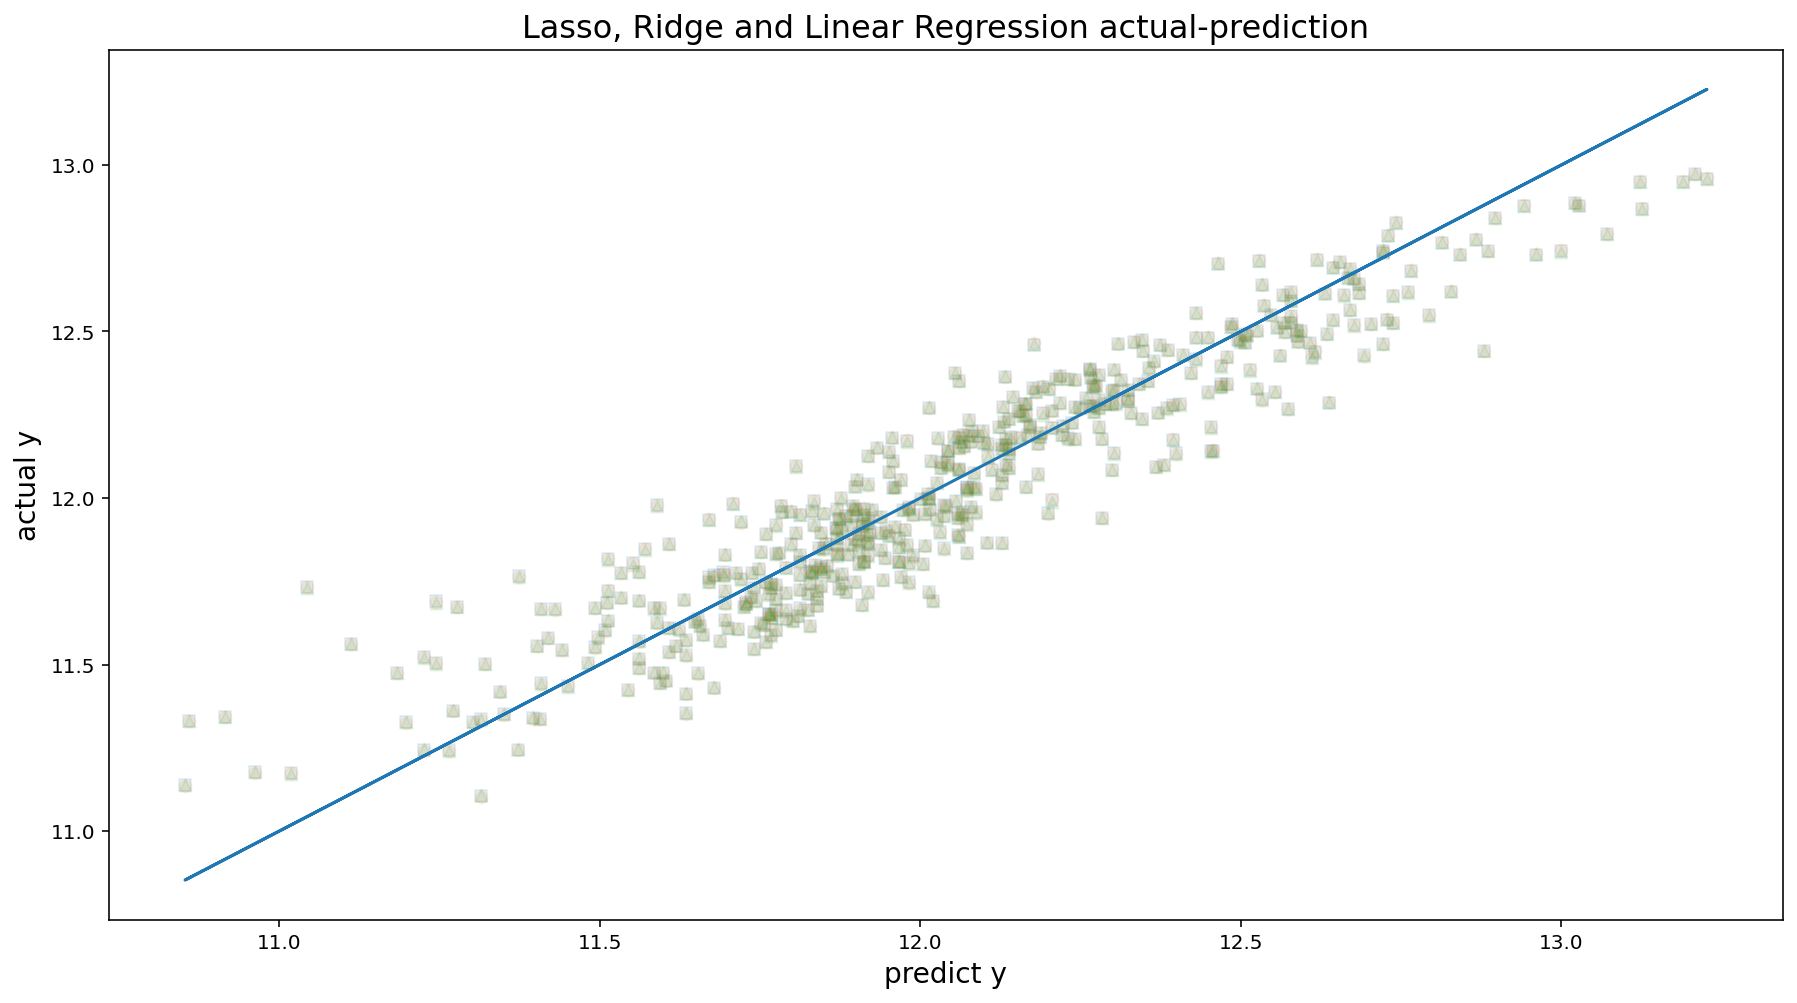

In [24]:
# plot on scatter plot to observe
plt.figure(figsize=(15,8))
plt.scatter(ys_test, lasso.predict(Xs_test), alpha=0.1, marker='s')
plt.scatter(y_test, lr.predict(X_test), alpha=0.1, marker='o')
plt.scatter(y_test, ridge.predict(X_test), alpha=0.1, marker='^')
plt.plot(y_test, y_test);
plt.ylabel('actual y', fontsize=14)
plt.xlabel('predict y', fontsize=14)
plt.title('Lasso, Ridge and Linear Regression actual-prediction', fontsize=16)
plt.show()
# looks about decent
# in fact the 3 models are similar with largely overlapping points!

### Modelling - checking residuals

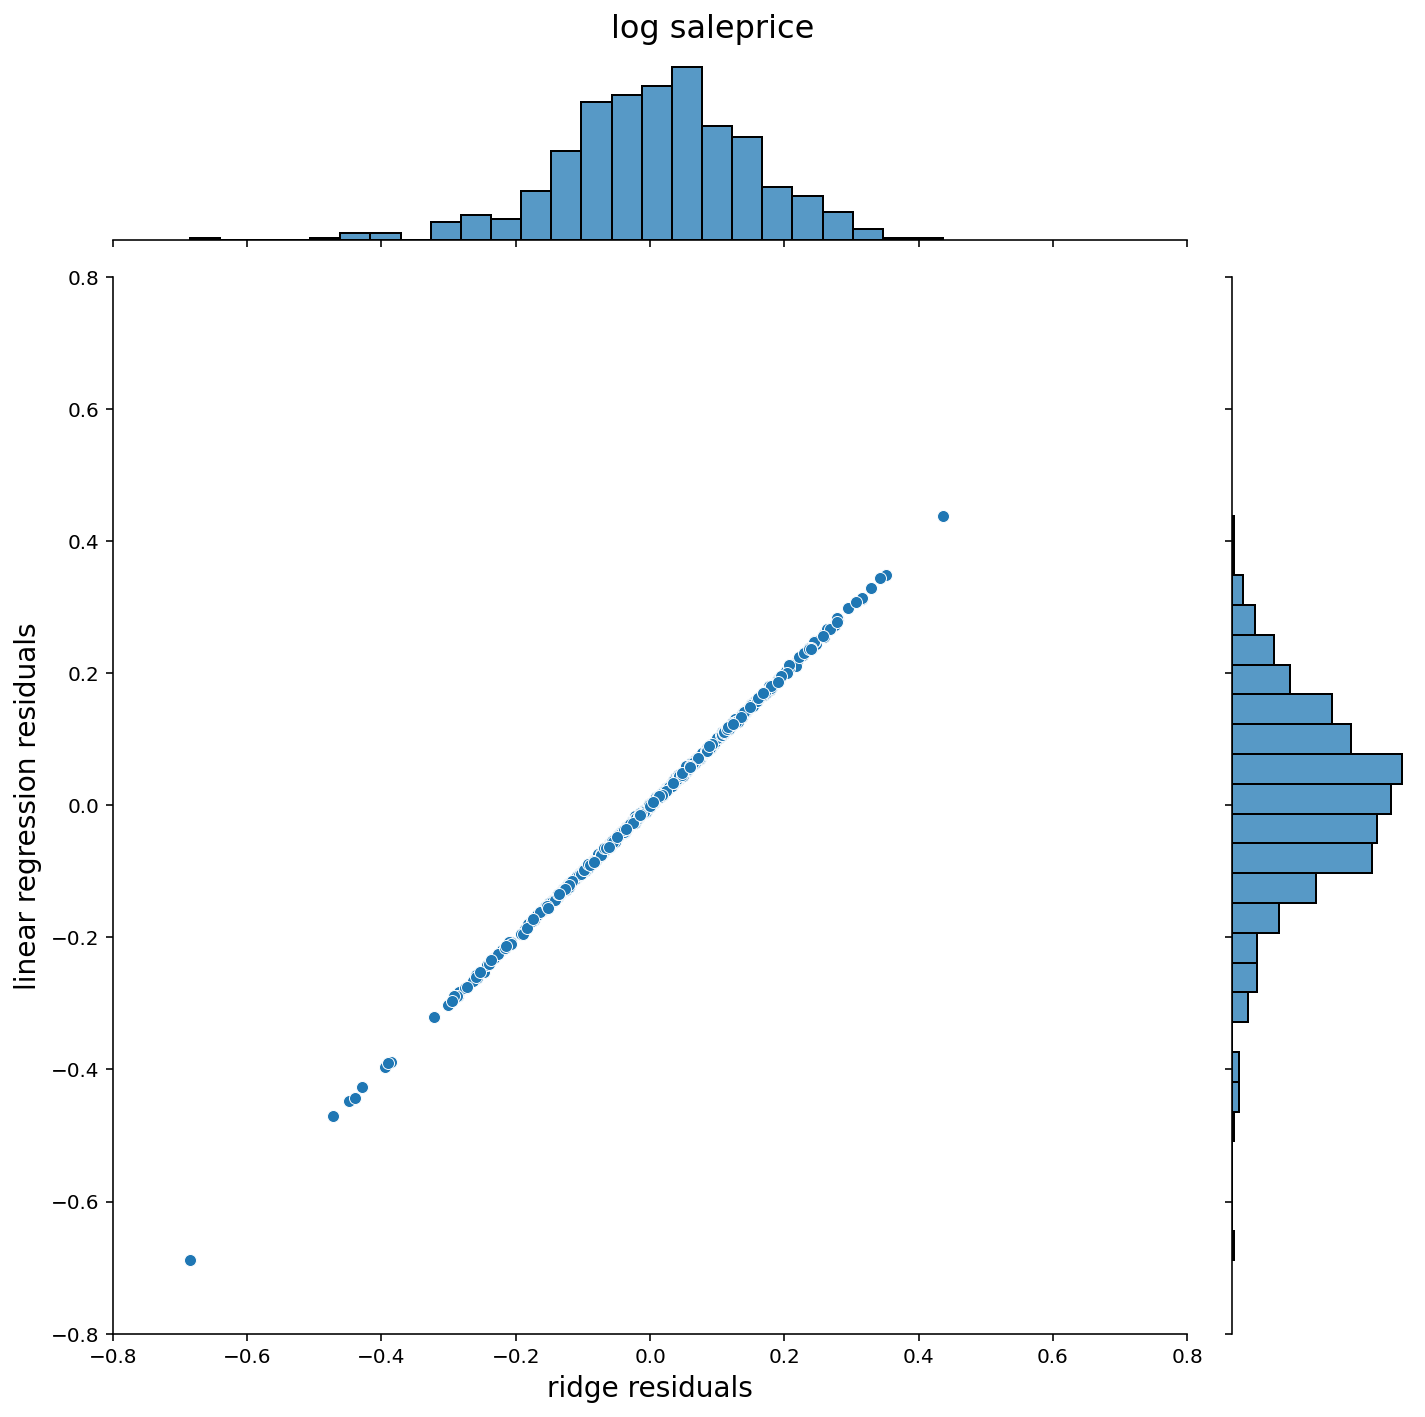

In [25]:
# take a look at the model residuals
ridge_resid = y_test - ridge.predict(X_test)
lr_resid = y_test - lr.predict(X_test)
jp_plot = sns.jointplot(x=ridge_resid, y=lr_resid, xlim=(-0.8,0.8), ylim=(-0.8,0.8), height=10)
jp_plot.set_axis_labels('ridge residuals', 'linear regression residuals', fontsize=14)
jp_plot.fig.suptitle('log saleprice', fontsize=16)
plt.tight_layout();

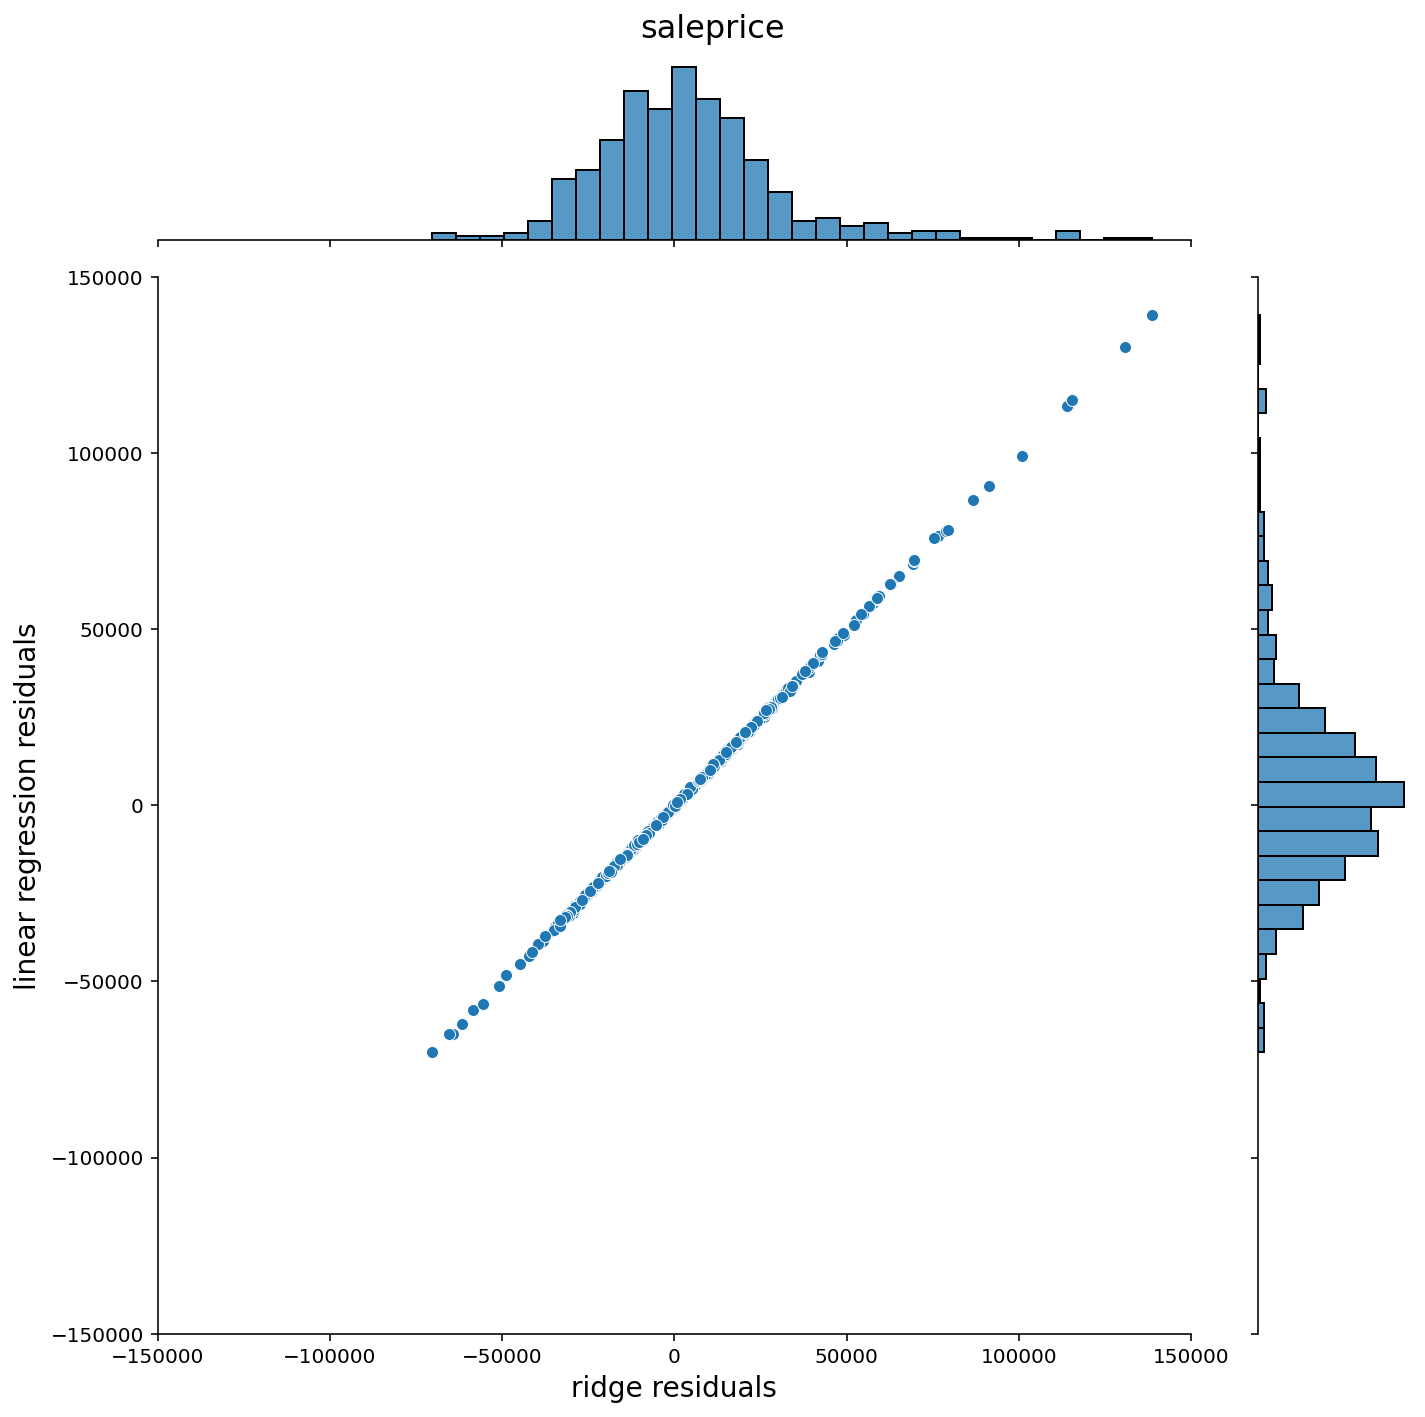

In [26]:
# take a look at the model residuals in original scale
ridge_resid = np.exp(y_test) - np.exp(ridge.predict(X_test))
lr_resid = np.exp(y_test) - np.exp(lr.predict(X_test))
jp_plot = sns.jointplot(x=ridge_resid, y=lr_resid, xlim=(-150000,150000), ylim=(-150000,150000), height=10)
jp_plot.set_axis_labels('ridge residuals', 'linear regression residuals', fontsize=14)
jp_plot.fig.suptitle('saleprice', fontsize=16)
plt.tight_layout();

In [27]:
# deriving the rmse in original scale
ridge_resid_sq = ((np.exp(y_test) - np.exp(ridge.predict(X_test)))**2)
lr_resid_sq = ((np.exp(y_test) - np.exp(lr.predict(X_test)))**2)
ridge_resid_rmse = (ridge_resid_sq.sum() / ridge_resid_sq.count())**0.5
lr_resid_rmse = (lr_resid_sq.sum() / lr_resid_sq.count())**0.5
print(f'ridge residuals rmse : {ridge_resid_rmse:.0f}')
print(f'linear regression residuals rmse : {lr_resid_rmse:.0f}')

ridge residuals rmse : 28260
linear regression residuals rmse : 28202


Comments:\
Both the scatter and the residuals look fine, which is supported by the R-sq score and the RMSE.\
Having said that, the residuals as a function of mean sale price is about ~15%. This is not that small.

### Model evaluation - metrics comparison

In [28]:
# simplest model - mean of sale price
y_base = np.mean(y_train)
base_rmse_train = np.sqrt(np.mean((y_train - y_base)**2))
base_rmse_test = np.sqrt(np.mean((y_test - y_base)**2))

In [29]:
# train test R-sq scores at a glance
print(f'lasso train R-sq : {lasso.score(Xs_train, ys_train):.5f}')
print(f'lasso test R-sq : {lasso.score(Xs_test, ys_test):.5f}\n')
print(f'ridge train R-sq : {ridge.score(X_train, y_train):.5f}')
print(f'ridge test R-sq : {ridge.score(X_test, y_test):.5f}\n')
print(f'linear regression train R-sq : {lr.score(X_train, y_train):.5f}')
print(f'linear regression test R-sq : {lr.score(X_test, y_test):.5f}')

lasso train R-sq : 0.86296
lasso test R-sq : 0.87552

ridge train R-sq : 0.86294
ridge test R-sq : 0.87557

linear regression train R-sq : 0.86296
linear regression test R-sq : 0.87557


In [30]:
# check out the cross val scores
print(f'lasso train cvs : {cross_val_score(lasso, Xs_train, ys_train).mean():.5f}')
print(f'lasso test cvs : {cross_val_score(lasso, Xs_test, ys_test).mean():.5f}\n')
print(f'ridge train cvs : {cross_val_score(ridge, X_train, y_train).mean():.5f}')
print(f'ridge test cvs : {cross_val_score(ridge, X_test, y_test).mean():.5f}\n')
print(f'linear regression train cvs : {cross_val_score(lr, X_train, y_train).mean():.5f}')
print(f'linear regression test cvs : {cross_val_score(lr, X_test, y_test).mean():.5f}')

lasso train cvs : 0.85810
lasso test cvs : 0.87309

ridge train cvs : 0.85813
ridge test cvs : 0.87315

linear regression train cvs : 0.85809
linear regression test cvs : 0.87307


In [31]:
# take a look at the most important criteria for kaggle judgement, rmse
print(f'baseline train rmse : {base_rmse_train:.5f}')
print(f'baseline test rmse : {base_rmse_test:.5f}\n')
print(f'lasso train rmse : {np.sqrt(metrics.mean_squared_error(ys_train, lasso.predict(Xs_train))):.5f}')
print(f'lasso test rmse : {np.sqrt(metrics.mean_squared_error(ys_test, lasso.predict(Xs_test))):.5f}\n')
print(f'ridge train rmse : {np.sqrt(metrics.mean_squared_error(y_train, ridge.predict(X_train))):.5f}')
print(f'ridge test rmse : {np.sqrt(metrics.mean_squared_error(y_test, ridge.predict(X_test))):.5f}\n')
print(f'linear regression train rmse : {np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train))):.5f}')
print(f'linear regression test rmse : {np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test))):.5f}')

baseline train rmse : 0.38527
baseline test rmse : 0.40471

lasso train rmse : 0.14262
lasso test rmse : 0.14265

ridge train rmse : 0.14263
ridge test rmse : 0.14262

linear regression train rmse : 0.14262
linear regression test rmse : 0.14262


Comments:\
As I have mentioned, this is the step where I would return to the selection of random state as part of model tuning - a step that I have placed above just before the random state selection although it would not be out of place if I had parked it in this step here. Nonetheless, this is just to make a point that the modelling process is iterative.\
From the above, the RMSE between the train and test have low variance, which was the very selection criteria for random state as discussed earlier.\
Based on the above metrics, all three models (lasso, ridge, linear regression) are virtually identical.\
However, either ridge or linear regression are preferred as the coefficients are not scaled, providing the best ease of interpretation. In this case, I have opted for linear regression as it is simpler than ridge without the penalty constant in play since there is no difference between the models.

# Conclusion

Putting everything together and interpret the model.\
Assemble the model coefficients and constant.\
Verify that the modelled equation works and understand the meaning of the modelled coefficients.

### Review chosen model coefficients and constant

In [32]:
print(f'linear regression model intercept : {lr.intercept_:.5f}')
print(f'linear regression model exp(intercept) : {np.exp(lr.intercept_):.3f}')

linear regression model intercept : 7.55384
linear regression model exp(intercept) : 1908.052


In [33]:
# display selected model coefficients
constant = np.exp(lr.intercept_)
lr_coef=lr_coef.append({'feature':'constant', 'coef_(A)':lr.intercept_}, ignore_index=True)
lr_coef

,feature,coef_(A)
0,overall_qual,0.054738
1,neighborhood,0.073011
2,log_gr_liv_area,0.323098
3,kitchen_qual,0.060082
4,garage_cars,0.045313
5,garage,0.006991
6,bsmt_qual,0.041331
7,log_1st_flr_sf,0.180217
8,full_bath,-0.036363
9,fireplace_qu,0.017307


### Model coefficient interpretation - adjusting for natural log function on sale price

In [34]:
# taking the exponential to rescale the coefficient from the current target variable 'natural log(saleprice)',
# back to original unit for saleprice in $
lr_coef['exp_coef_(B)'] = np.exp(lr_coef['coef_(A)'])
lr_coef.sort_values(by='exp_coef_(B)', ascending=False).round(4)

,feature,coef_(A),exp_coef_(B)
12,constant,7.5538,1908.0520
2,log_gr_liv_area,0.3231,1.3814
7,log_1st_flr_sf,0.1802,1.1975
1,neighborhood,0.0730,1.0757
3,kitchen_qual,0.0601,1.0619
0,overall_qual,0.0547,1.0563
4,garage_cars,0.0453,1.0464
6,bsmt_qual,0.0413,1.0422
9,fireplace_qu,0.0173,1.0175
5,garage,0.0070,1.0070


### Model interpretation - example trials on coefficient understanding

In [35]:
# constructing a dataframe to prediction values
single_x_data = X_train.loc[0,:].values
single_x_data = np.hstack([single_x_data, 1])
lr_coef['example_(X)'] = single_x_data
lr_coef['example_(raw X)'] = lr_coef['example_(X)']
lr_coef.loc[2,'example_(raw X)'] = np.exp(lr_coef.loc[2,'example_(X)'])
lr_coef.loc[7,'example_(raw X)'] = np.exp(lr_coef.loc[7,'example_(X)'])
lr_coef['A*X'] = lr_coef['coef_(A)'] * lr_coef['example_(X)']
lr_coef['exp(A*X)'] = np.exp(lr_coef['A*X'])
X_price = lr_coef['exp(A*X)'].product()
print(f'example house price = ${X_price:.0f}')

example house price = $153390


In [36]:
# test example, impact when each variable increases by 1 unit

# X1 test: if overall quality increases by 1 rating
lr_coef['X1'] = lr_coef['example_(X)']
lr_coef.loc[0,'X1'] = 7
X1_price = (np.exp(lr_coef['coef_(A)']*lr_coef['X1'])).product()

# X2 test: if basement rating increases by 1 rating
lr_coef['X2'] = lr_coef['example_(X)']
lr_coef.loc[6,'X2'] = 4
X2_price = (np.exp(lr_coef['coef_(A)']*lr_coef['X2'])).product()

# recall: ln(p+q) = ln(p) + ln(1+q/p)
# X3 test: if log_gr_liv_area increase by 1 unit (in base units, 2.718x increase or ~2541 square-foot increase)
lr_coef['X3'] = lr_coef['example_(X)']
lr_coef.loc[2,'X3'] = np.log(1479+2541.3388)
X3_price = (np.exp(lr_coef['coef_(A)']*lr_coef['X3'])).product()

X1_msg = (f'new house price when overall quality increase by 1 = ${X1_price:.0f},'
          f'an increase of ${(X1_price - X_price):.0f} or {(X1_price/X_price):4f}x')

X2_msg = (f'new house price when basement quality increase by 1 = ${X2_price:.0f},'
          f'an increase of ${(X2_price - X_price):.0f} or {(X2_price/X_price):4f}x')

X3_msg = (f'new house price when grade living area increase by 2541 sq-ft (1-unit increase in logscale) = ${X3_price:.0f},'
          f' an increase of ${(X3_price - X_price):.0f} or {(X3_price/X_price):4f}x') 
print(X1_msg)
print(X2_msg)
print(X3_msg)
print(f'therefore, column exp_coef_(B) or B-variable is the multiplicative impact of 1 unit increase in X-variable')


new house price when overall quality increase by 1 = $162021,an increase of $8630 or 1.056264x
new house price when basement quality increase by 1 = $159863,an increase of $6473 or 1.042197x
new house price when grade living area increase by 2541 sq-ft (1-unit increase in logscale) = $211894, an increase of $58503 or 1.381401x
therefore, column exp_coef_(B) or B-variable is the multiplicative impact of 1 unit increase in X-variable


In [37]:
lr_coef

,feature,coef_(A),exp_coef_(B),example_(X),example_(raw X),A*X,exp(A*X),X1,X2,X3
0,overall_qual,0.054738,1.056264,6.000000,6.0,0.328427,1.388782,7.000000,6.000000,6.000000
1,neighborhood,0.073011,1.075742,1.000000,1.0,0.073011,1.075742,1.000000,1.000000,1.000000
2,log_gr_liv_area,0.323098,1.381401,7.299121,1479.0,2.358335,10.573330,7.299121,7.299121,8.299121
3,kitchen_qual,0.060082,1.061923,4.000000,4.0,0.240326,1.271664,4.000000,4.000000,4.000000
4,garage_cars,0.045313,1.046356,2.000000,2.0,0.090627,1.094860,2.000000,2.000000,2.000000
5,garage,0.006991,1.007016,12.000000,12.0,0.083896,1.087516,12.000000,12.000000,12.000000
6,bsmt_qual,0.041331,1.042197,3.000000,3.0,0.123993,1.132008,3.000000,4.000000,3.000000
7,log_1st_flr_sf,0.180217,1.197477,6.586172,725.0,1.186938,3.277030,6.586172,6.586172,6.586172
8,full_bath,-0.036363,0.964290,2.000000,2.0,-0.072726,0.929856,2.000000,2.000000,2.000000
9,fireplace_qu,0.017307,1.017458,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000


### Save model with pickle

In [38]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(lr, open(filename,'wb'))

### Technical conclusion

Through the deployment of a supervised machine learning regression model, i.e. providing known dataset to the machine to run an ordinary least squares regression, I am able to derive an optimum model after tuning for the hyperparameters on L1 and L2 penalties through Lasso and Ridge respectively. A simpler linear regression was also conducted to compare the respective models performance.

Given the results, my choice of model would be between ridge and linear regression. Both have very similar R-sq, RMSE, even the coefficients, and they are really not that different. Lasso is not selected as the lasso model has been scaled, therefore its coefficients needs to be rescaled before we can make meaningful interpretation. Thus, since there are no significant advantages in adopting the lasso model, I have narrowed my selection to between ridge and linear regression.

| model             | test R-sq | test RMSE |
|:------------------|:---------:|:---------:|
|lasso	            |  0.87552  |  0.14266  |
|ridge	            |  0.87558  |  0.14262  |
|linear regression  |  0.87557  |  0.14262  |

Since the linear regression model and ridge are similar, I have chosen the linear regression model for simplicity. (recurring theme :)\
Because the y-variable is log sale price, the model coefficient needs to be transformed into an exp(coefficient) which I have already done so below.\
Given all things equal, for every unit increase in any of the below feature, there will be a corresponding multiplicative impact on the sale price as shown in the table.\
E.g. If say, a house in a particular neighbourhood is currently valued at 200k\\$.\
If we compare it to an identical and adjadent house with similar attributes save for its the overall quality being higher by 1 rating, say from 6 to 7 (in a scale of one to ten).\
In this case, the model predicts that the sale price of the house will be higher by a magnitude of 1.0563x, to 211k\\$.\
We can also use this model to compare houses with different attributes to understand their expected difference in sale price.


Details in the below table:

| feature          | multiplicative impact for 1 unit increase in feature |       description       |
|:-----------------|:---------------------------------------:|:-------------------------------------|
|log_gr_liv_area   |       1.3814          | natural log of grade living area of the house          |
|log_1st_flr_sf    |       1.1975          | natural log of 1st floor square footage of the house   |
|neighborhood	   |       1.0757          | neighborhood precinct of the house (note 6)            |
|kitchen_qual	   |	   1.0619          | kitchen quality (note 1)                               |
|overall_qual      |       1.0563          | overall material and finishing quality (note 2)        |
|garage_cars	   |	   1.0464          | size of garage in cars capacity                        |
|bsmt_qual         |       1.0422          | height of the basement (note 3)                        |
|fireplace_qu      |       1.0175          | fireplace quality (note 4)                             |
|garage		       |       1.0070          | garage attributes (note 5)                             |
|age_at_sale       |       0.9995          | age of the house                                       |
|remod_age_at_sale |       0.9985          | number of years since last remodelling done            |
|full_bath	       |       0.9643          | number of full bathrooms above grade                   |

Notes: refer to data dictionary for further details.\
note 1 - kitchen quality on a scale of 1-5, where 1=poor and 5=excellent\
note 2 - overall material and finishing quality on a scale of 1-10, where 1=very poor and 10=very excellent\
note 3 - basement quality in terms of its height on a scale of 1-5, where 1=very poor, 5=excellent and 0=no basement\
note 4 - fireplace quality on a scale of 1-5, where 1=very poor, 5=excellent and 0=no fireplace\
note 5 - garage attributes, an amalgamation of garage type * garage finish * garage quality, where

|garage type (gt) | gt assigned value |garage finish (gf)| gf assigned value|garage quality (gq)| gq assigned value|
|:----------------|:-----------------:|:-----------------|:----------------:|:------------------|:----------------:|
|attached         |          2        |finished          |          2       |excellent          |         5        |
|detached         |          1        |rough finished    |          2       |good               |         4        |
|builtin          |          2        |unfinished        |          1       |typical            |         3        |
|basement         |          1        |no garage         |          0       |fair               |         2        |
|2Types           |          1        |                  |                  |poor               |         1        |
|carport          |          1        |                  |                  |no garage          |         0        |
|no garage        |          0        |

note 6 - neighborhood groupings as follows:

| neighborhood | group |
|:----------|:-----:|
|	Blmngtn	|	2	|
|	Blueste	|	1	|
|	BrDale	|	1	|
|	BrkSide	|	1	|
|	ClearCr	|	2	|
|	CollgCr	|	2	|
|	Crawfor	|	2	|
|	Edwards	|	1	|
|	Gilbert	|	2	|
|	Greens	|	2	|
|	GrnHill	|	3	|
|	IDOTRR	|	1	|
|	Landmrk	|	1	|
|	MeadowV	|	1	|
|	Mitchel	|	2	|
|	NAmes	|	1	|
|	NoRidge	|	3	|
|	NPkVill	|	1	|
|	NridgHt	|	3	|
|	NWAmes	|	2	|
|	OldTown	|	1	|
|	Sawyer	|	1	|
|	SawyerW	|	2	|
|	Somerst	|	2	|
|	StoneBr	|	3	|
|	SWISU	|	1	|
|	Timber	|	2	|
|	Veenker	|	2	|

### Recommendations to target audience

As home seekers, you might be particularly interested in certain neighbourhoods to buy a house at, or if you are keen to know how the sale price of the house vary with their attributes and properties. If you have a specific query regarding these, I could certainly help with providing you details on the expected price differences.

For example, some attributes that you may be considering could be the size of the house, the kitchen quality, the garage quality, the age of the house, etc.\
As an illustration, if you are considering between 2 similar adjacent houses in the same neighbourhood. And these houses are quite similar except that one has an excellent quality fireplace while another does not have a fireplace. Then you are looking at a 9% price difference between them.

Lets say the one without a fireplace costs \\$200k, the one with the excellent fireplace will cost you \\$18k more at \\$218k.\
If you have a very specific house that you are looking at, given their attributes, I could also provide you with an expected sale price of the house.

Knowing the expected damage to your pocket could help you assess if you are willing to pay for a better quality feature or if the extra costs are not worthwhile.

So wait no longer, sign up as me for a comprehensive housing consulting service and makes your house hunting endeavour seamless and stress-free.

# Appendix

Run an OLS statsmodel to compare the results vs linear regression.

In [39]:
# run a statsmodel OLS to compare
X_sm = features.drop(columns = ['log_saleprice'])
#X_sm.head()

In [40]:
# take a look at stats summary
Xsm_train, Xsm_test, ysm_train, ysm_test = train_test_split(X_sm, y, random_state=rs)
Xsm_train = sm.add_constant(Xsm_train)
Xsm_test = sm.add_constant(Xsm_test)
model_sm = sm.OLS(ysm_train, Xsm_train).fit()
model_sm.summary()
# seems like the chosen features are alright
# except maybe year built can be dropped without really affecting the model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     794.5
Date:                Fri, 22 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:46:50   Log-Likelihood:                 807.23
No. Observations:                1527   AIC:                            -1588.
Df Residuals:                    1514   BIC:                            -1519.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.5538      0.131     57.658      0.000       7.297       7.811
overall_qual          0.0547      0.005     11.335      0.000       0.045       0.064
neighborhood          0.0730      0.009      8.088      0.000       0.055       0.091
log_gr_liv_area       0.3231      0.019     16.723      0.000       0.285       0.361
kitchen_qual          0.0601      0.008      7.277      0.000       0.044       0.076
garage_cars           0.0453      0.007      6.637      0.000       0.032       0.059
garage                0.0070      0.001      5.759      0.000       0.005       0.009
bsmt_qual             0.0413      0.006      6.968      0.000       0.030       0.053
log_1st_flr_sf        0.1802      0.014     12.765      0.000       0.153       0.208
full_bath            -0.0364      0.010     -3.745      0.000      -0.055      -0.017
fireplace_qu          0.0173      0.003      6.843      0.000       0.012       0.022
remod_age_at_sale    -0.0015      0.000     -5.743      0.000      -0.002      -0.001
age_at_sale          -0.0005      0.000     -2.443      0.015      -0.001      -0.000
==============================================================================
Omnibus:                      485.089   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4107.534
Skew:                          -1.236   Prob(JB):                         0.00
Kurtosis:                      10.645   Cond. No.                     1.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
# remove the age_at_sale if we insist on a 99% confidence level and observe any change in model
X_sm = features.drop(columns = ['log_saleprice', 'age_at_sale'])
Xsm_train, Xsm_test, ysm_train, ysm_test = train_test_split(X_sm, y, random_state=rs)
Xsm_train = sm.add_constant(Xsm_train)
Xsm_test = sm.add_constant(Xsm_test)
model_sm = sm.OLS(ysm_train, Xsm_train).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     863.4
Date:                Fri, 22 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:46:50   Log-Likelihood:                 804.23
No. Observations:                1527   AIC:                            -1584.
Df Residuals:                    1515   BIC:                            -1520.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.5722      0.131     57.799      0.000       7.315       7.829
overall_qual          0.0553      0.005     11.438      0.000       0.046       0.065
neighborhood          0.0794      0.009      9.182      0.000       0.062       0.096
log_gr_liv_area       0.3101      0.019     16.671      0.000       0.274       0.347
kitchen_qual          0.0602      0.008      7.284      0.000       0.044       0.076
garage_cars           0.0475      0.007      6.999      0.000       0.034       0.061
garage                0.0081      0.001      7.154      0.000       0.006       0.010
bsmt_qual             0.0446      0.006      7.704      0.000       0.033       0.056
log_1st_flr_sf        0.1824      0.014     12.928      0.000       0.155       0.210
full_bath            -0.0315      0.010     -3.306      0.001      -0.050      -0.013
fireplace_qu          0.0167      0.003      6.614      0.000       0.012       0.022
remod_age_at_sale    -0.0016      0.000     -6.438      0.000      -0.002      -0.001
==============================================================================
Omnibus:                      476.983   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3817.383
Skew:                          -1.229   Prob(JB):                         0.00
Kurtosis:                      10.346   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Comments:\
Based on the OLS model results, except for 'age_at_sale' with a p-value of 0.015, all the other variables have a p-value<0.001.\
Save for age at sale, we can say with 99% confidence that we reject H0: that there is no relationship between sale price and the chosen features and accept Ha that there is a statistical significant relationship between these features and the sale price.\
Perhaps most houses have been remodelled and thus, the original age of the house is not as significant.